In [1]:
from unittest.mock import right

from torch.backends.mkl import verbose
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries


## Read data

In [2]:
electricity_consumption = pd.read_csv("../WeatherPreprocessing/WeatherBusinessResidential.csv")
electricity_consumption

,Date,Total Rainfall Mm,Mean Air Temperature in Celsius,Mean Vapour Pressure Hpa,Mean Wind Speed M/Sec,Days Of Wind Gust >= 24 Knots in Day,Standard Deviation Of Daily Mean Temperature in Celsius,Year,Month,Selected business demand (GWh),Est. Total consumption (GWh)
0,2010-01-01,41.90,20.05,17.40,4.20,11.0,1.70,2010.0,1.0,572.918,282.000
1,2010-02-01,34.80,21.35,19.70,3.65,8.0,1.20,2010.0,2.0,564.809,259.792
2,2010-03-01,7.60,19.30,16.65,4.35,12.5,1.45,2010.0,3.0,621.988,295.270
3,2010-04-01,48.40,17.05,16.05,3.15,7.0,1.40,2010.0,4.0,573.259,303.576
4,2010-05-01,197.50,14.60,14.40,3.55,12.5,1.95,2010.0,5.0,608.594,363.480
...,...,...,...,...,...,...,...,...,...,...,...
169,2024-02-01,43.80,20.35,17.85,3.70,3.5,1.30,2024.0,2.0,574.002,311.724
170,2024-03-01,55.65,17.90,15.60,4.10,10.5,2.10,2024.0,3.0,581.184,337.730
171,2024-04-01,81.95,16.95,15.95,3.65,8.0,1.80,2024.0,4.0,555.174,348.859
172,2024-05-01,115.75,13.35,12.80,3.75,11.5,1.75,2024.0,5.0,593.551,452.473


In [3]:
# read immigration data
# immigration = pd.read_csv("../immigrationData/immigration_population_type.csv")
# immigration['Date'] = pd.to_datetime(immigration['Date'], format='%Y-%m-%d')
# immigration['Date'] = immigration['Date'] - pd.offsets.MonthEnd(1) + pd.offsets.Day(1)
# electricity_consumption['Date'] = pd.to_datetime(electricity_consumption['Date'], format='%Y-%m-%d')
# electricity_consumption = electricity_consumption.merge(immigration, on='Date', how='left')


In [4]:
# Convert dataframe to Timeseries
ts = TimeSeries.from_dataframe(electricity_consumption, time_col="Date" )

<Axes: xlabel='Date'>

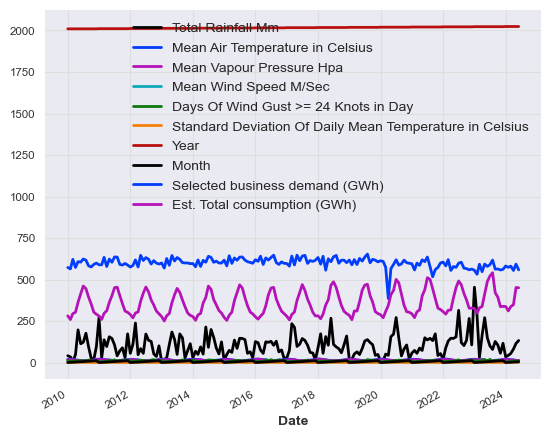

In [5]:
ts.plot()

<Axes: xlabel='Date'>

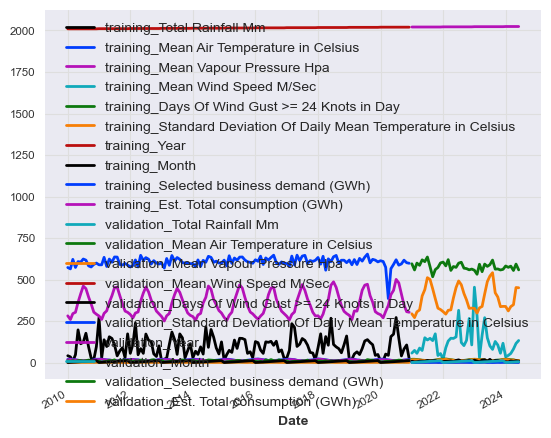

In [6]:
# training and validation split
train, val = ts.split_before(pd.Timestamp('2021-01-01'))
train.plot(label='training')
val.plot(label='validation')

## Preprocessing

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import shutil
from sklearn.preprocessing import MinMaxScaler

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape, mae, rmse
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

scaler = MinMaxScaler(feature_range=(0, 1))
transformer = Scaler(scaler)
transformer_target = Scaler(scaler)

train_target_og = train['Est. Total consumption (GWh)']
val_target_og = val['Est. Total consumption (GWh)']
train_target = transformer_target.fit_transform(train_target_og)
val_target = transformer_target.transform(val_target_og)

train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(ts)

#split past covariates
train_past_cov = train_transformed[['Days Of Wind Gust >= 24 Knots in Day', 'Mean Air Temperature in Celsius', 'Mean Vapour Pressure Hpa']]
val_past_cov = val_transformed[['Days Of Wind Gust >= 24 Knots in Day', 'Mean Air Temperature in Celsius', 'Mean Vapour Pressure Hpa']]

# replace missing value with the mean of column
train_past_cov = train_past_cov.pd_dataframe()
train_past_cov = train_past_cov.apply(lambda col: col.fillna(col.mean()))
train_past_cov = TimeSeries.from_dataframe(train_past_cov)



In [27]:
series_transformed = series_transformed.pd_dataframe()
series_transformed = series_transformed.apply(lambda col: col.fillna(col.mean()))
series_transformed = TimeSeries.from_dataframe(series_transformed)

## Model training and testing

In [8]:
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [37]:
model_gru = BlockRNNModel(
    model="GRU",
    n_rnn_layers=3,
    hidden_dim=100,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-2},
    model_name="Electricity_GRU",
    log_tensorboard=True,
    input_chunk_length=36,
    save_checkpoints=True,
    force_reset = True,
    output_chunk_length=42,
    random_state=20
)

model_gru.fit(train_target,
   past_covariates = train_past_cov,
    verbose=False)

BlockRNNModel(output_chunk_shift=0, model=GRU, hidden_dim=100, n_rnn_layers=3, hidden_fc_sizes=None, dropout=0.0, n_epochs=100, optimizer_kwargs={'lr': 0.01}, model_name=Electricity_GRU, log_tensorboard=True, input_chunk_length=36, save_checkpoints=True, force_reset=True, output_chunk_length=42, random_state=20)

Predicting: |          | 0/? [00:00<?, ?it/s]

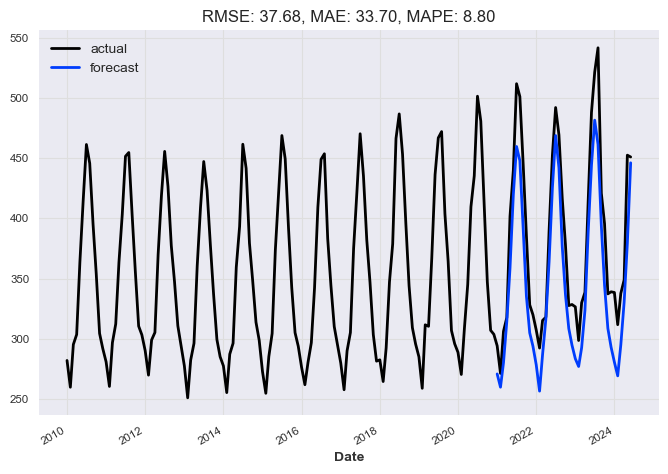

In [38]:
def eval_model(model):
    pred_series = model.predict(n=42)
    plt.figure(figsize=(8, 5))
    pred_series_reversed = transformer_target.inverse_transform(pred_series)
    ts['Est. Total consumption (GWh)'].plot(label="actual")
    pred_series_reversed['Est. Total consumption (GWh)'].plot(label="forecast")
    
    plt.title("RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}".format(rmse(val_target_og, pred_series_reversed), mae(val_target_og, pred_series_reversed), mape(val_target_og, pred_series_reversed)))
    plt.legend()
    return pred_series

pred_series_transformed = eval_model(model_gru)


In [156]:
mae(transformer_target.inverse_transform(val_target), transformer_target.inverse_transform(pred_series_transformed))

28.705175229582125

## Backtesting using 3 month forecast horizon

In [ ]:
backtest_series = model_gru.historical_forecasts(
    series_transformed['Est. Total consumption (GWh)'],

    start=pd.Timestamp("20180101"),
    forecast_horizon=3,
    retrain=True,
    verbose=False,
)

backtest_series_reversed = transformer_target.inverse_transform(backtest_series)

plt.figure(figsize=(8, 5))
ts['Est. Total consumption (GWh)'].plot(label="actual")
backtest_series_reversed.plot(label="backtest")
plt.legend()
plt.title("Backtest, starting Jan 2018, 3-months horizon")
print(
    "MAPE: {:.2f}%".format(
        mape(
            ts['Est. Total consumption (GWh)'],
            backtest_series_reversed,
        )
    )
)

In [33]:
backtest_series_reversed.pd_dataframe()

component,Est. Total consumption (GWh)
time,
2018-03-01,278.632250
2018-04-01,309.675610
2018-05-01,377.056785
2018-06-01,435.221911
2018-07-01,454.522450
2018-08-01,410.312217
2018-09-01,356.544042
2018-10-01,319.971028
2018-11-01,297.653191


In [28]:
series_transformed['Est. Total consumption (GWh)']

component,Total Rainfall Mm,Mean Air Temperature in Celsius,Mean Vapour Pressure Hpa,Mean Wind Speed M/Sec,Days Of Wind Gust >= 24 Knots in Day,Standard Deviation Of Daily Mean Temperature in Celsius,Year,Month,Selected business demand (GWh),Est. Total consumption (GWh)
Date,,,,,,,,,,
2010-01-01,0.129875,0.797357,0.653061,0.611111,0.545455,0.342105,0.0,0.000000,0.698370,0.123807
2010-02-01,0.102991,0.911894,0.887755,0.407407,0.363636,0.078947,0.0,0.090909,0.668095,0.035130
2010-03-01,0.000000,0.731278,0.576531,0.666667,0.636364,0.210526,0.0,0.181818,0.881573,0.176794
2010-04-01,0.154487,0.533040,0.515306,0.222222,0.303030,0.184211,0.0,0.272727,0.699643,0.209960
2010-05-01,0.719046,0.317181,0.346939,0.370370,0.636364,0.473684,0.0,0.363636,0.831567,0.449157
...,...,...,...,...,...,...,...,...,...,...
2024-02-01,0.137069,0.823789,0.698980,0.425926,0.090909,0.131579,1.4,0.090909,0.702417,0.242495
2024-03-01,0.181939,0.607930,0.469388,0.574074,0.515152,0.552632,1.4,0.181818,0.729231,0.346337
2024-04-01,0.281522,0.524229,0.505102,0.407407,0.363636,0.394737,1.4,0.272727,0.632123,0.390775
